# Hyperparemeter Optimization using Keras Tuner

[KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)  is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. Easily configure your search space with a define-by-run syntax, then leverage one of the available search algorithms to find the best hyperparameter values for your models. KerasTuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in.

**Install** keras_tuner package:
`$ pip install keras-tuner`

# Import required packages/APIs

In [1]:
from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras_tuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report

2021-08-16 14:27:02.023829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mldev/ATM/pkgs/R-deps/zlib/zlib_1.2.8/lib:/home/mldev/ATM/pkgs/R-deps/pcre/pcre_8.35/lib:/home/mldev/ATM/pkgs/R-deps/xz/xz_5.2.3/lib:/home/mldev/ATM/pkgs/R-deps/bzip2/bzip2_1.0.6/lib:/usr/local/cuda/lib64::/home/mldev/ATM/pkgs/R-deps/curl/curl_7.49.0/lib:/home/mldev/ATM/pkgs/R-deps/R_3.6.0/lib64:/home/mldev/ATM/pkgs/libxml/libxml2_2.7.3/lib
2021-08-16 14:27:02.023881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load and prepare Data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [3]:
# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [4]:
y_train = y_train.reshape(-1,)
y_val = y_val.reshape(-1,)
y_test = y_test.reshape(-1,)

# Model-building function
Define a model-building function. It takes an argument `hyperparameter` from which you can sample hyperparameters, such as `hyperparameter.Int('units', min_value=32, max_value=512, step=32)` (an integer from a certain range).

This function returns a compiled model.

In [8]:
def create_model(hyperparameter):
    # Define Sequential Model
    model = Sequential()
    
    # Add Convolution Layer 1
    model.add(Conv2D(
        filters = hyperparameter.Int('conv_1_filter',min_value=32, max_value=128, step=16), 
        kernel_size = hyperparameter.Choice('conv_1_kernel', values = [3,6]),
        activation = 'relu',
        input_shape = (32, 32, 3)))
    
    # Add MaxPooling Layer 1
    model.add(MaxPooling2D((2, 2)))
    
    # Add Convolution Layer 2
    model.add(Conv2D(
        filters = hyperparameter.Int('conv_2_filter',min_value=64, max_value=256, step=16), 
        kernel_size = hyperparameter.Choice('conv_2_kernel', values = [3,6]),
        activation = 'relu'))
    
    # Add MaxPooling Layer 2
    model.add(MaxPooling2D((2, 2)))

                  
    # Add Flatten Layer
    model.add(Flatten())
    
    # Add Dense Layer 1
    model.add(Dense(
        units = hyperparameter.Choice('dense_1_units', [32, 64, 128]), 
        activation='relu'))
    
    # Add Output layer
    model.add(Dense(10, activation='softmax'))
    
    # Complie model with learning_rate hyperparmeter for optimizer        
    model.compile(optimizer=Adam(hyperparameter.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

# Instantiate a tuner
Specify
- the model-building function(`create_model`),
- the name of the `objective` to optimize (whether to minimize or maximize is automatically inferred for built-in metrics),
- the total number of trials (`max_trials`) to test, and
- the number of models that should be built and fit for each trial (`executions_per_trial`).

In [9]:
hpo_tuner = RandomSearch(create_model,
                       objective='val_accuracy',
                       max_trials=5,
                       executions_per_trial=2)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
# hpo_tuner.search_space_summary()

# Start the search for the best hyperparameter configuration
The call to search method is the same as `model.fit()`

In search, models are built iteratively by calling the model-building function, which populates the hyperparameter space (search space) tracked by the `hyperparameter` object. The tuner progressively explores the space, recording metrics for each configuration.

In [10]:
# search the best parameters
hpo_tuner.search(X_train, y_train,
                 epochs=20,
                 validation_data=(X_val, y_val))

Trial 5 Complete [00h 05m 52s]
val_accuracy: 0.708299994468689

Best val_accuracy So Far: 0.708299994468689
Total elapsed time: 00h 39m 08s
INFO:tensorflow:Oracle triggered exit


# Get Best Model

In [22]:
model = hpo_tuner.get_best_models()[0]

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 96)        2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 224)       193760    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 224)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8064)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                516160    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [33]:
model.save("cnn-model.h5", save_format="h5")

# Model Evaluation

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.9438 - accuracy: 0.6961


In [32]:
print(f"Accuracy on test data = {round(accuracy,2)*100}%")

Accuracy on test data = 70.0%


In [64]:
# Prediction on model returns the probability for each class
model.predict(X_test)[0]

array([2.7171341e-03, 2.0046127e-05, 1.7689879e-04, 6.4574689e-01,
       1.2884212e-04, 2.7708134e-01, 7.4256640e-03, 1.4141076e-05,
       6.5797321e-02, 8.9171715e-04], dtype=float32)

In [42]:
# We need to get the index value of maximum probability in each prediction.
# argmax returns the indices of the maximum values along the given axis.
predictions = model.predict(X_test).argmax(axis=1) 

In [65]:
predictions

array([3, 1, 8, ..., 5, 4, 7])

In [43]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1000
           1       0.85      0.78      0.81      1000
           2       0.54      0.62      0.58      1000
           3       0.56      0.52      0.54      1000
           4       0.68      0.57      0.62      1000
           5       0.64      0.59      0.62      1000
           6       0.75      0.78      0.77      1000
           7       0.71      0.77      0.74      1000
           8       0.82      0.77      0.80      1000
           9       0.74      0.83      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [46]:
cm = confusion_matrix(y_test, predictions)

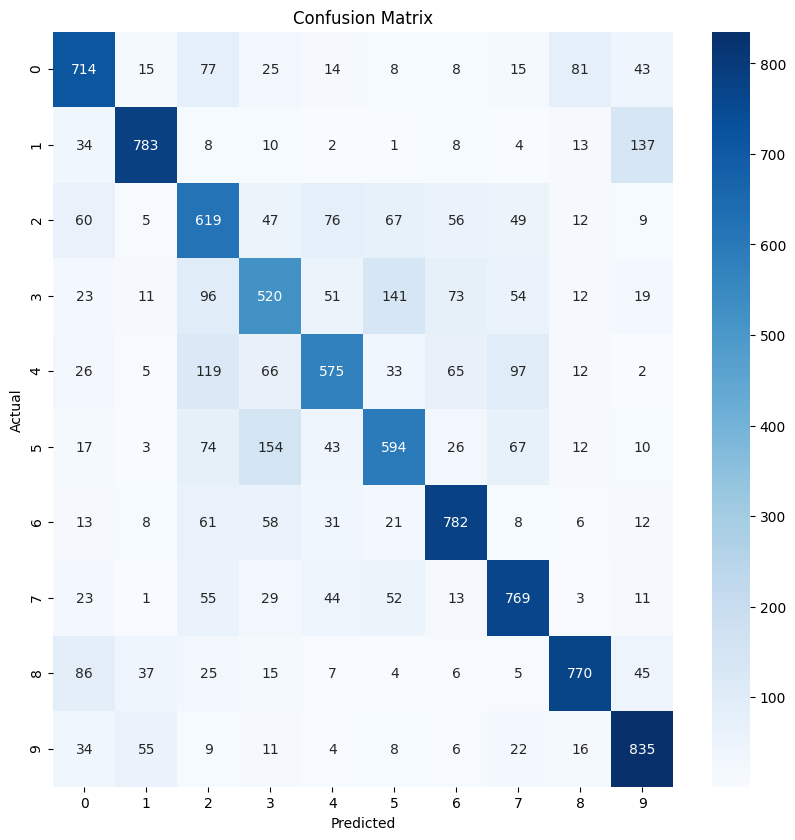

In [59]:
plt.figure(dpi=100, figsize=(10,10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()